In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import keras
import keras.models as models
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import BatchNormalization, Input, Add, Concatenate, concatenate
from keras.layers import TimeDistributed, LSTM
from keras.layers.convolutional import Conv2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import model_from_json, load_model
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from keras.callbacks import ModelCheckpoint
import cv2
import os
import csv
import numpy as np
import json
import matplotlib.pyplot as plt
from pathlib import Path
from keras.callbacks import CSVLogger

In [3]:
steering = (10,20)
minS = 15
maxS = 15.7
n = 2

In [4]:
def load_images(path):
    # initialize loop variables
    numImages = 0
    inputs = []
    processDataPath = path + "ProcessData.csv"
    if not os.path.isfile(processDataPath):
        print('ProcessData.csv must be in folder %s' %path)
        return
    # read images in ProcessData.csv and append to input
    with open(processDataPath, 'rt') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            numImages = numImages+1
            if not os.path.isfile(path + (row[0].lower())):
                print('%s not found.' %(path+(row[0].lower())))
                return
            image=cv2.imread(path + (row[0].lower()))
            img = cv2.resize(image, (200, 66))
            img = img / 255.
            inputs.append(img)
    print("Total number of images: %d" %numImages)
    return inputs

In [5]:
def read_output_data(path):
    Y=[]
    A=[]
    # ensure path exists
    processDataPath = path+"ProcessData.csv"
    if not os.path.isfile(processDataPath):
        print('ProcessData.csv not found in %s.' %path)
        return
    # open ProcessData.csv and append steering values and speeds to Y and A
    with open(processDataPath, 'rt') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            output = []
            y = (float(row[1]) - steering[0]) / (steering[1] - steering[0])
            output.append(y)
            Y.append(output)
            output1 = []
            x = (float(row[2]) - minS) / (maxS - minS)
            output1.append(x)
            A.append(output1)
    # return list of steering values and speeds
    return A, Y

In [6]:
def loadData(path):
    X = load_images(path)
    A, Y = read_output_data(path)
    X = np.array(X)
    A = np.array(A)
    Y = np.array(Y)
    return X, A, Y

In [7]:
def split_sequence(sequence, n_steps):
  x = list()
  for i in range(len(sequence)):
    end_ix = i + n_steps
    if end_ix > len(sequence) - 1:
      break
    seq_x = sequence[i:end_ix]
    x.append(seq_x)
  return np.array(x)

In [39]:
def createLSTMModel():
  model = Sequential()
  input1 = Input(shape=(n, 66, 200, 3), name='images')
  input2 = Input(shape=(n,1), name='speed')
  input3 = Input(shape=(n,1), name='steering')
  
  steer_inp = TimeDistributed(BatchNormalization(epsilon=0.001, axis=-1, momentum=0.99))(input1)
  layer1 = TimeDistributed(Conv2D(24, (5, 5), padding="valid", strides=(2, 2), activation="relu"))(steer_inp)
  layer2 = TimeDistributed(Conv2D(36, (5, 5), padding="valid", strides=(2, 2), activation="relu"))(layer1)
  layer3 = TimeDistributed(Conv2D(48, (5, 5), padding="valid", strides=(2, 2), activation="relu"))(layer2)
  layer4 = TimeDistributed(Conv2D(64, (3, 3), padding="valid", strides=(1, 1), activation="relu"))(layer3)
  layer5 = TimeDistributed(Conv2D(64, (3, 3), padding="valid", strides=(1, 1), activation="relu"))(layer4)
  layer6 = TimeDistributed(Flatten())(layer5)
  # layer7 = TimeDistributed(Dense(1164, activation='relu'))(layer6)
  layer8 = LSTM(128)(layer6)
  layer9 = Dense(50, activation='relu')(layer8)

  layer10 = LSTM(128)(input2)
  layer11 = Dense(25, activation='relu')(layer10)

  layer12 = LSTM(128)(input3)
  layer13 = Dense(25, activation='relu')(layer12)
  
  merged = Concatenate()([layer9, layer11, layer13])
  layer14 = Dense(50, activation='relu')(merged)
  layer15 = Dense(50, activation='relu')(layer14)
  layer16 = Dense(10, activation='relu')(layer15)
  steer_out = Dense(1, activation='relu')(layer16)
  speed_out = Dense(1, activation='relu')(layer16)
  out = concatenate([steer_out, speed_out])
  model = Model(inputs=[input1,input2,input3], outputs=speed_out)
  model.summary()
  return model

In [40]:
history = CSVLogger('kerasloss.csv', append=True, separator=';')
def trainModel(model, image, steering, speed, output_steering, output_speed):
    adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='mse', optimizer=adam)
    filePath = "weights.best.hdf5"
    checkpoint = ModelCheckpoint(filePath, monitor='loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint, history]
    model.fit([image, speed, steering], output_speed, epochs=200, batch_size=64, callbacks=callbacks_list, verbose=1)

In [10]:
train_path = '/content/drive/My Drive/Colab Notebooks/Test1/'
X, A, Y = loadData(train_path)

print(X.shape)
print(Y.shape)
print(A.shape)

Total number of images: 3000
(3000, 66, 200, 3)
(3000, 1)
(3000, 1)


In [11]:
train_image = split_sequence(X, n)
train_steering = split_sequence(Y, n)
train_speed = split_sequence(A, n)
train_Y_steering = Y[n:]
train_Y_speed = A[n:]

print(train_image.shape)
print(train_steering.shape)
print(train_speed.shape)
print(train_Y_steering.shape)
print(train_Y_speed.shape)

(2998, 2, 66, 200, 3)
(2998, 2, 1)
(2998, 2, 1)
(2998, 1)
(2998, 1)


In [41]:
LSTM_model = createLSTMModel()
trainModel(LSTM_model, train_image, train_steering, train_speed, train_Y_steering, train_Y_speed)

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 2, 66, 200,  0                                            
__________________________________________________________________________________________________
time_distributed_35 (TimeDistri (None, 2, 66, 200, 3 12          images[0][0]                     
__________________________________________________________________________________________________
time_distributed_36 (TimeDistri (None, 2, 31, 98, 24 1824        time_distributed_35[0][0]        
__________________________________________________________________________________________________
time_distributed_37 (TimeDistri (None, 2, 14, 47, 36 21636       time_distributed_36[0][0]        
______________________________________________________________________________________

In [13]:
testPath = '/content/drive/My Drive/Colab Notebooks/DeepNNCar_Train1/'
Xtest, Atest, Ytest = loadData(testPath)
print(Xtest.shape)
print(Ytest.shape)
print(Atest.shape)

Total number of images: 1076
(1076, 66, 200, 3)
(1076, 1)
(1076, 1)


In [14]:
test_image = split_sequence(Xtest, n)
test_steering = split_sequence(Ytest, n)
test_speed = split_sequence(Atest, n)
test_Y_steering = Ytest[n:]
test_Y_speed = Atest[n:]

print(test_image.shape)
print(test_steering.shape)
print(test_speed.shape)
print(test_Y_steering.shape)
print(test_Y_speed.shape)

(1074, 2, 66, 200, 3)
(1074, 2, 1)
(1074, 2, 1)
(1074, 1)
(1074, 1)


In [42]:
from keras.models import load_model
saved_model = load_model("weights.best.hdf5")
outputs = saved_model.predict([test_image, test_speed, test_steering], batch_size=1)

0.021568994857137046


Text(0.5, 1.0, 'Actual Steering vs Predicted Steering')

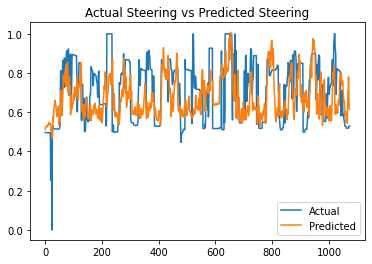

In [38]:
mse = metrics.mean_squared_error(outputs, test_Y_steering)
print(mse)
plt.plot(test_Y_steering)
plt.plot(outputs)
plt.legend(['Actual', 'Predicted'])
plt.title('Actual Steering vs Predicted Steering')

0.019892129315616514


Text(0.5, 1.0, 'Actual Speed vs Predicted Speed')

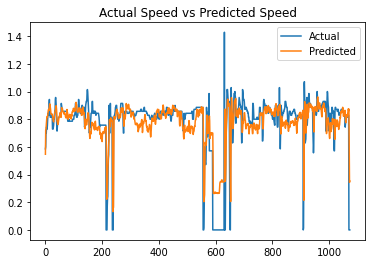

In [43]:
mse = metrics.mean_squared_error(outputs, test_Y_speed)
print(mse)
plt.plot(test_Y_speed)
plt.plot(outputs)
plt.legend(['Actual', 'Predicted'])
plt.title('Actual Speed vs Predicted Speed')